In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as nn_utils
import zuko
from torch.optim import lr_scheduler

from itertools import islice
from tqdm import tqdm

from lampe.data import JointLoader
from lampe.inference import NPE, NPELoss
from lampe.plots import nice_rc, corner, mark_point
from lampe.utils import GDStep
from lampe.data import H5Dataset
from lampe.diagnostics import expected_coverage_mc

import h5py
import numpy as np

from datetime import datetime

/home/opt/python/anaconda3.8_TF2.5/envs/torch_1.12.1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


这段代码是一个Jupyter Notebook文件的开始部分，用于设置环境和导入必要的库。它为后续的深度学习任务，尤其是与神经过程估计（NPE）相关的任务，做好准备。以下是对各个组成部分的分析：

### 环境设置
- `%matplotlib inline`：这是一个Jupyter Notebook的魔法命令，用于将`matplotlib`生成的图形内嵌在笔记本内显示，而不是在新窗口中。

### 库导入
- `matplotlib.pyplot`：用于数据可视化。
- `torch`及其子模块（`nn`, `optim`, `nn.utils`）：PyTorch库，用于构建和训练深度学习模型。
- `torch.optim.lr_scheduler`：提供了不同的学习率调整策略。
- `zuko`：这看起来像是一个自定义库或者第三方库，但在这里无法确定其具体用途。
- `itertools.islice`和`tqdm`：分别用于迭代器切片和在循环中提供进度条。
- `lampe.data`, `lampe.inference`, `lampe.plots`, `lampe.utils`, `lampe.diagnostics`：`lampe`似乎是一个专门用于数据加载、神经过程估计（NPE）、绘图、实用工具和诊断的库。这表明了笔记本涉及到使用NPE进行推理、数据处理和结果可视化。
- `h5py`：用于处理HDF5格式的数据文件，这是一种用于存储和组织大量数据的文件格式。
- `numpy`：提供高性能的多维数组对象及相关工具，是科学计算中常用的库。
- `datetime`：用于处理日期和时间。

### 用途概述
这段代码显示了该Jupyter Notebook用于深度学习，特别是涉及到使用NPE进行推理的项目。导入的库覆盖了数据处理（`numpy`, `h5py`, `lampe.data`）、模型构建和训练（`torch`及其子模块）、学习率调整（`torch.optim.lr_scheduler`）、结果可视化（`matplotlib.pyplot`, `lampe.plots`）和性能评估（`lampe.diagnostics`）等各个方面。此外，通过导入`zuko`和`lampe`库，该文件似乎使用了特定的研究或项目特定的工具和方法。整体而言，这段代码为深入分析、模型训练和结果评估等后续步骤奠定了基础。

In [2]:
#  "act<class 'torch.nn.modules.activation.ReLU'>学习率0.0003,正则化0.001,休眠率0.2,参数数目1024,参数层数7,流层9,中间层256,最佳损失-5.820067882537842,训练周期28",
#"act<class 'torch.nn.modules.activation.ReLU'>学习率0.0003,正则化0,休眠率0.2,参数数目1024,参数层数7,流层9,中间层512,最佳损失-3.325531482696533,训练周期35",
torch.backends.cudnn.deterministic = True #禁用 cuDNN 的随机性，从而保证每次运行的结果都是相同的。
for act in [nn.ReLU]:
  for f in [0.0001]:
    for weight_decay in [0]:
       for liu in [zuko.flows.NSF]:
        for transfomr in [7]:#特征提取的blocks
         for num in [4096]:
          for trans in [9]:#NF的残差块--画图的
           for beishu in [2048]:
            now= datetime.now()
            def fix_bn(m):
                classname = m.__class__.__name__
                if classname.find('BatchNorm') != -1:
                    m.eval()
            def weight_init(m):
                if isinstance(m, (nn.Conv1d, nn.Linear)):
                    nn.init.xavier_uniform_(m.weight.data)#kaiming_normal_///xavier_uniform_
                    nn.init.constant_(m.bias.data, 0.0)

            class Bottlrneck(torch.nn.Module):
                def __init__(self,In_channel,Med_channel,Out_channel,downsample=False):
                    super(Bottlrneck, self).__init__()
                    self.stride = 1
                    if downsample == True:
                        self.stride = 2
                    #在这里添加BatchNorm1d和Dropout是最合适的
                    self.layer = torch.nn.Sequential(
                        torch.nn.Conv1d(In_channel, Med_channel, 1, self.stride),
                        torch.nn.BatchNorm1d(Med_channel),
                        torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Med_channel, 3, padding=1),
                        torch.nn.BatchNorm1d(Med_channel),
                        #torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Out_channel, 1),
                        torch.nn.BatchNorm1d(Out_channel),
                        #torch.nn.ReLU(),
                    )

                    if In_channel != Out_channel:
                        self.res_layer = torch.nn.Conv1d(In_channel, Out_channel,1,self.stride)
                    else:
                        self.res_layer = None

                    self.jia_relu=torch.nn.Sequential(torch.nn.ReLU())

                def forward(self,x):
                    if self.res_layer is not None:
                        residual = self.res_layer(x)
                    else:
                        residual = x
                    return self.jia_relu(self.layer(x)+residual)
                
                def forward(self,x):
                    if self.res_layer is not None:
                        residual = self.res_layer(x)
                    else:
                        residual = x
                    return self.layer(x)+residual

            class ResNet(torch.nn.Module):
                def __init__(self,in_channels=1,classes=5):
                    super(ResNet, self).__init__()
                    self.features = torch.nn.Sequential(
                        torch.nn.Conv1d(in_channels,64,kernel_size=7,stride=2,padding=3),##in_channels*x*x--->64*x/2*x/2
                        torch.nn.MaxPool1d(3,2,1),#池化——64*x/4*x/4

                        Bottlrneck(64,64,256,False),
                        Bottlrneck(256,64,256,False),
                        Bottlrneck(256,64,256,False),#256*x/4*x/4



                        Bottlrneck(256,128,512, True),#True代表卷积步长为2————256*x/8*x/8
                        Bottlrneck(512,128,512, False),
                        Bottlrneck(512,128,512, False),
                        Bottlrneck(512,128,512, False),



                        Bottlrneck(512,256,1024, True),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),



                        Bottlrneck(1024,512,2048, True),
                        Bottlrneck(2048,512,2048, False),
                        Bottlrneck(2048,512,2048, False),

                        torch.nn.AdaptiveAvgPool1d(1)#变成2048*1*1
                    )
                    self.classifer = torch.nn.Sequential(
                        torch.nn.Linear(2048,classes)#变成每类特征的信息
                    )
                    

                def forward(self,x):
                    x = self.features(x)
                    x = x.view(-1,2048)
                    x = self.classifer(x)
                    return x

            class NPEWithEmbedding(nn.Module):#!这个网络只要是1维的2的倍数就行 // 它将神经过程估计器（NPE）与嵌入网络（之前定义的ResNet）相结合。这种设置表明，该模型旨在学习输入数据的表示（使用ResNet），然后应用这些表示进行进一步的处理或NPE组件的推理
                def __init__(self,channels=3,beishu=4,canshu=2,build=zuko.flows.NSF,hidden_features=[128] * 3,activation=nn.ELU,transforms=3):
                    super().__init__()

                    self.npe = NPE(canshu, beishu, build=build, hidden_features=hidden_features,transforms=transforms, activation=activation)#用于
                    self.embedding = ResNet(in_channels=channels,classes=beishu)

                def forward(self, theta: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
                    #print(self.embedding(x).shape)

                    return self.npe(theta, self.embedding(x))

                def flow(self, x: torch.Tensor):  # -> flow对应原来的采样，因为他调用的就是flow
                    return self.npe.flow(self.embedding(x))
                

            torch.manual_seed(2234)#重置参数，在循环里面可以保证可以复现
            
            
            estimator_NPE= NPEWithEmbedding(channels=4,canshu=2,beishu=beishu,build=liu,hidden_features=[num] * transfomr,transforms=trans,activation=act).cuda()#beishu是残差网络输出尺寸（npe的输入参数）
            estimator_NPE.apply(weight_init);
            estimator_NPE.load_state_dict(torch.load("/home/DATA/suntianyang/gw_len/net/net/NPE_mid_t_lens.pth"))
            loss = NPELoss(estimator_NPE);
            estimator_NPE.cuda();
            estimator_NPE.train();
            estimator_NPE.apply(fix_bn) 
            estimator_NPE.eval();

该代码片段为特定任务定义并初始化深度学习模型，可能与图像或信号处理有关，因为它使用了一维卷积。这个代码片段有点复杂，包含了来自深度学习的各种技术和组件。以下是其关键功能的总结:

1. **确定性行为**:将cuDNN的行为设置为确定性，确保每次运行的结果都是可重复的，这对调试和比较至关重要。

2. * * * *模型定义:
-定义了一个` bottrneck `类，这似乎是一个自定义的瓶颈层，通常在ResNet架构中用于深度残差学习。该层包括批量归一化和ReLU激活，并具有下采样选项。
-定义了一个`ResNet`类，它代表了适用于一维输入(例如，时间序列数据)的ResNet架构的变体。该架构使用之前定义的“瓶颈”层，并包括一个自适应平均池化层，以在分类之前将特征维度降低到固定大小。
-定义一个` npewithembed `类，它将神经过程估计器(NPE)与嵌入网络(之前定义的ResNet)相结合。这种设置表明，该模型旨在学习输入数据的表示(使用ResNet)，然后将这些表示应用于NPE组件的进一步处理或推理。

3. * *模型初始化* *:
-使用Xavier均匀初始化初始化卷积层和线性层的权重，这是帮助深度网络收敛的常见做法。
-为PyTorch的随机数生成器设置手动种子，以确保可重复性。

4. **模型实例化和准备**:
-使用特定参数实例化` npewithembed `模型，表明NPE模型使用ResNet模型产生的嵌入的复杂设置。
-将预训练的权重加载到模型中，表明模型正在准备进行进一步的微调训练或推理。
-为训练准备模型，包括将其设置为CUDA以进行GPU加速，应用自定义权重初始化，并固定批归一化层的行为以进行评估。

5. **训练和评估准备**:模型在训练和评估模式之间切换。这涉及到应用自定义函数来修改批处理规范化层(`fix_bn`)的行为，然后将模型设置为评估模式。这种设置对于模型的行为需要在不同使用阶段保持一致的任务至关重要，例如训练、验证和测试。

总之，这段代码概述了PyTorch的高级用法，用于定义、初始化和准备具有特定任务的自定义架构和行为的深度学习模型。对可重复性的关注，通过确定性行为和人工播种，以及涉及ResNet用于嵌入和NPE用于处理的组合的复杂设置，表明了高度专业化的应用。

In [3]:
for act in [nn.ReLU]:
  for f in [0.0001]:
    for weight_decay in [0]:
       for liu in [zuko.flows.NSF]:
        for transfomr in [7]:#特征提取的blocks
         for num in [4096]:
          for trans in [9]:#NF的残差块--画图的
           for beishu in [2048]:
            now= datetime.now()
            def weight_init(m):
                if isinstance(m, (nn.Conv1d, nn.Linear)):
                    nn.init.xavier_uniform_(m.weight.data)#kaiming_normal_///xavier_uniform_
                    nn.init.constant_(m.bias.data, 0.0)

            class Bottlrneck(torch.nn.Module):
                def __init__(self,In_channel,Med_channel,Out_channel,downsample=False):
                    super(Bottlrneck, self).__init__()
                    self.stride = 1
                    if downsample == True:
                        self.stride = 2
                    #在这里添加BatchNorm1d和Dropout是最合适的
                    self.layer = torch.nn.Sequential(
                        torch.nn.Conv1d(In_channel, Med_channel, 1, self.stride),
                        torch.nn.BatchNorm1d(Med_channel),
                        torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Med_channel, 3, padding=1),
                        torch.nn.BatchNorm1d(Med_channel),
                        #torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Out_channel, 1),
                        torch.nn.BatchNorm1d(Out_channel),
                        #torch.nn.ReLU(),
                    )

                    if In_channel != Out_channel:
                        self.res_layer = torch.nn.Conv1d(In_channel, Out_channel,1,self.stride)
                    else:
                        self.res_layer = None

                    self.jia_relu=torch.nn.Sequential(torch.nn.ReLU())

                def forward(self,x):
                    if self.res_layer is not None:
                        residual = self.res_layer(x)
                    else:
                        residual = x

                    return self.jia_relu(self.layer(x)+residual)

            class ResNet(torch.nn.Module):
                def __init__(self,in_channels=1,classes=5):
                    super(ResNet, self).__init__()
                    self.features = torch.nn.Sequential(
                        torch.nn.Conv1d(in_channels,64,kernel_size=7,stride=2,padding=3),##in_channels*x*x--->64*x/2*x/2
                        torch.nn.MaxPool1d(3,2,1),#池化——64*x/4*x/4

                        Bottlrneck(64,64,256,False),
                        Bottlrneck(256,64,256,False),
                        Bottlrneck(256,64,256,False),#256*x/4*x/4



                        Bottlrneck(256,128,512, True),#True代表卷积步长为2————256*x/8*x/8
                        Bottlrneck(512,128,512, False),
                        Bottlrneck(512,128,512, False),
                        Bottlrneck(512,128,512, False),



                        Bottlrneck(512,256,1024, True),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),



                        Bottlrneck(1024,512,2048, True),
                        Bottlrneck(2048,512,2048, False),
                        Bottlrneck(2048,512,2048, False),

                        torch.nn.AdaptiveAvgPool1d(1)#变成2048*1*1
                    )
                    self.classifer = torch.nn.Sequential(
                        torch.nn.Linear(2048,classes)#变成每类特征的信息
                    )
                    

                def forward(self,x):
                    x = self.features(x)
                    x = x.view(-1,2048)
                    x = self.classifer(x)
                    return x

这段代码是一个定义深度神经网络结构的例子，特别是对于处理1D数据的ResNet模型的变体。它包括自定义的瓶颈层（`Bottlrneck`）和整个ResNet模型的实现。下面是对代码的详细分析：

### Bottlrneck 类
- 这是一个自定义的瓶颈层，用于构建深度残差网络。它包括卷积层（`Conv1d`）、批量归一化层（`BatchNorm1d`）和ReLU激活函数。这种层通常用于构建深度学习中的残差网络（ResNet）。
- `downsample` 参数控制是否应用下采样（即通过设置卷积步长为2来减少数据的维度）。
- 如果输入通道数（`In_channel`）和输出通道数（`Out_channel`）不相等，则通过一个额外的卷积层（`res_layer`）来调整残差连接的维度以匹配主路径的输出。
- `forward` 方法定义了数据通过瓶颈层的前向传播路径。如果存在`res_layer`，它将应用于输入数据以产生残差；然后，将处理后的数据和残差相加，并通过ReLU激活函数。

### ResNet 类
- 这个类实现了一个针对1D数据的ResNet模型，开始于一个卷积层和最大池化层，然后是多个`Bottlrneck`层，最后是一个自适应平均池化层（`AdaptiveAvgPool1d`）。
- `in_channels` 表示输入数据的通道数，而`classes` 表示模型输出的类别数。
- 在`features`序列中，通过不同配置的`Bottlrneck`层逐步提取特征和降低特征维度，最终通过自适应平均池化层将特征图降维到一个固定大小的向量。
- `classifer` 序列包含一个线性层（`Linear`），用于将提取的特征映射到目标类别上。
- `forward` 方法定义了数据通过整个ResNet模型的前向传播路径，从`features`提取特征，然后通过`classifer`产生最终的类别预测。

总的来说，这段代码展示了如何使用PyTorch定义一个复杂的神经网络结构，特别是对于处理一维数据（如时间序列数据）的深度残差网络。这种网络结构广泛应用于各种深度学习任务中，包括图像和声音处理、时间序列分析等。通过自定义的瓶颈层和残差连接，ResNet模型能够有效地训练深层网络，解决了传统深层网络中的梯度消失和梯度爆炸问题。

In [4]:
model_NPE=torch.load(f'/home/DATA/suntianyang/gw_len/net/net/NPE_mid_t_lens_ce_all.pth')

# I-dt

In [15]:
#固定的参数

LOWER = torch.tensor([0  ,  0. ])
UPPER = torch.tensor([0.2 , 1. ])

#参数归一化与逆运算
def preprocess(theta: torch.Tensor) -> torch.Tensor:
    return 2 * (theta - LOWER) / (UPPER - LOWER) - 1

def postprocess(theta: torch.Tensor) -> torch.Tensor:
    return (theta + 1) / 2 * (UPPER - LOWER) + LOWER


def get_wave_plus_gaosnoise_t_gen_cai_NPE(data):
    nnnyyu=2**5
    samples_all=torch.zeros((data.shape[0],2,nnnyyu))
    for i in range(data.shape[0]):
        estimator_NPE.eval()
        with torch.no_grad():
            samples = estimator_NPE.flow(data[i].reshape(1,4,40960).cuda()).sample((nnnyyu,)).cpu()
            samples = postprocess(samples)
            
        samples_all[i,0,:]=samples[:,0,0]
        samples_all[i,1,:]=samples[:,0,1]
    return samples_all

这段代码主要涉及到数据预处理、后处理以及使用训练好的神经网络模型（在此上下文中是`estimator_NPE`）来生成样本数据。下面是详细的分析：

### 固定参数
- `LOWER` 和 `UPPER` 定义了参数的范围。这些范围在后面的预处理和后处理函数中用于将参数归一化和反归一化。

### 预处理和后处理函数
- `preprocess` 函数将输入的`theta`（参数）按照`LOWER`和`UPPER`的范围归一化到`[-1, 1]`区间内。这是一种常见的数据归一化技术，有助于改善模型的训练和收敛速度。
- `postprocess` 函数执行相反的操作，将归一化后的`theta`反归一化回原始参数空间。这在模型生成样本后，需要将样本转换回原始参数空间时非常有用。

### `get_wave_plus_gaosnoise_t_gen_cai_NPE` 函数
- 这个函数接受`data`参数，预期为一个多维张量，其中第一个维度是样本数量，其余维度包含每个样本的特征。
- `nnnyyu`变量定义了要生成的样本数量，这里是`2**5`即32个。
- `samples_all`初始化为一个全零张量，用于存储所有生成的样本。
- 在一个循环中，对`data`的每个样本：
  - 使用`estimator_NPE`的`flow`方法生成样本。`estimator_NPE`被设置为评估模式（`.eval()`）以确保使用模型的推断模式，并且不会进行梯度计算（使用`torch.no_grad()`上下文管理器）。
  - `data[i].reshape(1,4,40960)`将当前样本调整形状以符合模型的输入要求。
  - 生成的样本通过`postprocess`函数进行后处理，以将其转换回原始参数空间。
  - 将处理后的样本存储到`samples_all`中。注意，这里仅提取了每个样本的前两个参数（假设每个样本是二维的）。

总的来说，这段代码的目的是使用一个预训练的神经网络模型（在这里是一个可能的正态化流（Normalizing Flow）模型，`estimator_NPE`），对输入数据进行采样，并将采样的结果进行适当的后处理以转换回原始的参数空间。这种操作在各种应用中都很有用，比如在贝叶斯推断中生成后验分布的样本，或在任何需要根据模型生成数据的场景中。

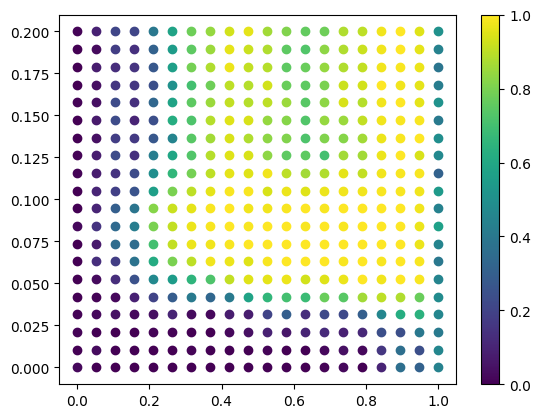

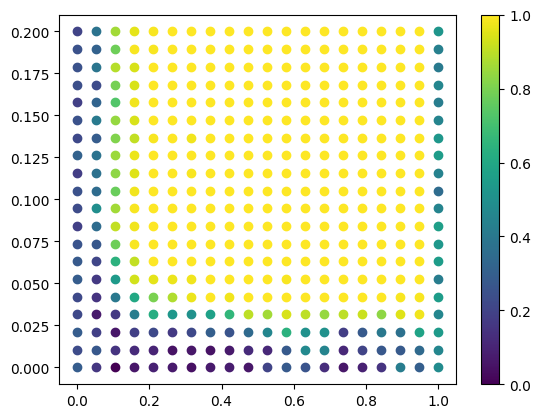

In [28]:
Z_L=0
for SNRRR in [16,24]:
    plt.figure()
    for I_tt in np.linspace(0,1,20):
        for dtt in np.linspace(0,0.2,20):
            
            all_x_vail_data=np.load(f'/home/DATA/suntianyang/gw_len/data/I_dt/test_PM_data_{I_tt}_{dtt}_{SNRRR}.npy')
            all_x_vail_data=torch.tensor(all_x_vail_data,dtype=torch.float32)
            
            all_x_vail=get_wave_plus_gaosnoise_t_gen_cai_NPE(all_x_vail_data).reshape(-1,2,2**5)

            y_pre_all=[]
            for i in range(all_x_vail.shape[0]):
                model_NPE.eval()
                with torch.no_grad():
                    y_pre = torch.sigmoid(model_NPE(all_x_vail[i].cuda()[np.newaxis, :]))
                y_pre_all.append(float(y_pre))

            
            threshold = 0.8
            # 根据阈值确定预测标签
            y_pre = (np.array(y_pre_all) >= threshold).astype(int)
            plt.scatter(I_tt,dtt,c=sum(y_pre)/100, vmin=0, vmax=1)
    plt.colorbar()
    plt.show()

这段代码通过遍历不同的信噪比（SNR）和两个参数`I_tt`与`dtt`的值，进行模型预测并可视化结果。具体步骤和元素如下：

### 变量初始化
- `Z_L`被设置为0，尽管在这段代码中没有被使用。
- `SNRRR`变量在循环中被设置为16和24，代表两个不同的信噪比（SNR）值。

### 循环与数据处理
- 外层循环遍历`SNRRR`中的值，内层循环遍历`I_tt`和`dtt`的值，`I_tt`从0到1，`dtt`从0到0.2，每个都是均匀分布的20个点。
- 对于每一组参数组合，通过numpy加载相应的测试数据文件，并将其转换为PyTorch张量。
- 使用`get_wave_plus_gaosnoise_t_gen_cai_NPE`函数处理加载的数据，该函数预计生成一系列基于给定输入的样本。

### 模型预测与可视化
- 对于`get_wave_plus_gaosnoise_t_gen_cai_NPE`函数生成的每个样本，使用`model_NPE`进行预测，将模型的输出通过sigmoid函数转换为概率值，并存储在`y_pre_all`列表中。
- 设置一个阈值（0.8），根据这个阈值将概率值转换为二分类预测结果（0或1）。
- 使用`plt.scatter`在散点图上表示每个参数组合的预测结果。点的颜色代表了预测为类别1的样本比例，颜色范围从0到1。
- 最后，为每个信噪比值绘制一个带有色标的散点图，色标代表预测为类别1的样本比例。

### 总结
这段代码的目的是评估和可视化`model_NPE`模型在不同信噪比和参数`I_tt`、`dtt`组合下的表现。通过在二维空间中遍历这些参数，并根据模型预测的标签比例着色，可以直观地展示模型对不同参数配置的响应。这种可视化方法有助于理解模型在参数空间中的行为，特别是在处理复杂数据或进行参数敏感性分析时。

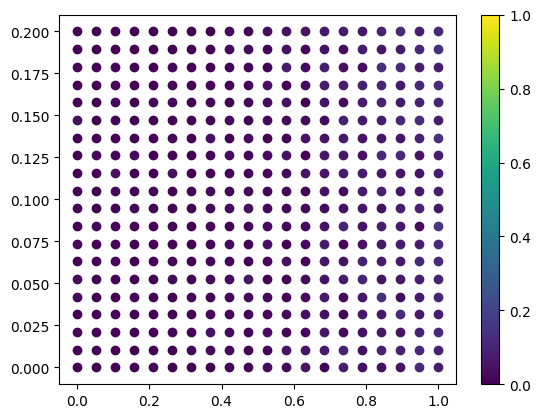

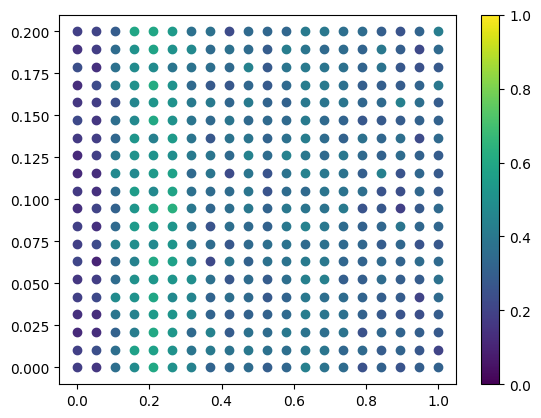

In [30]:

#固定的参数

Z_L=0
for SNRRR in [16,24]:
    plt.figure()
    for I_tt in np.linspace(0,1,20):
        for dtt in np.linspace(0,0.2,20):
            all_x_vail_data=np.load(f'/home/DATA/suntianyang/gw_len/data/I_dt/test_SIS_{1}_data_{I_tt}_{dtt}_{SNRRR}.npy')
            all_x_vail_data=torch.tensor(all_x_vail_data,dtype=torch.float32)
            
            all_x_vail=get_wave_plus_gaosnoise_t_gen_cai_NPE(all_x_vail_data).reshape(-1,2,2**5)

            y_pre_all=[]
            for i in range(all_x_vail.shape[0]):
                model_NPE.eval()
                with torch.no_grad():
                    y_pre = torch.sigmoid(model_NPE(all_x_vail[i].cuda()[np.newaxis, :]))
                y_pre_all.append(float(y_pre))

            
            threshold = 0.8
            # 根据阈值确定预测标签
            y_pre = (np.array(y_pre_all) >= threshold).astype(int)
            plt.scatter(I_tt,dtt,c=sum(y_pre)/100, vmin=0, vmax=1)


    plt.colorbar()
    plt.show()

这段代码与之前分析的非常相似，但是主要的区别在于它加载并处理的数据集不同。这里，数据集的命名中包含`test_SIS_{1}_data`，可能指向不同的实验设置或数据来源。下面是代码的关键点和流程概述：

### 固定参数和循环
- `Z_L`被初始化为0，但在这段代码中未使用。
- 通过两个嵌套循环遍历信噪比（SNR）值（16和24）以及`I_tt`和`dtt`的范围，这里`I_tt`在0到1之间，`dtt`在0到0.2之间，每个参数均匀分布20个点。

### 数据加载和预处理
- 对于每一组参数组合，从指定路径加载对应的测试数据文件，并将其转换为PyTorch张量格式。
- 使用`get_wave_plus_gaosnoise_t_gen_cai_NPE`函数对加载的数据进行处理，该函数基于给定的输入生成一系列样本。处理后的数据被重新整形为`(-1, 2, 2**5)`的形状。

### 模型预测和结果可视化
- 对于每个生成的样本，使用`model_NPE`进行预测。模型首先被设置为评估模式，以确保使用推断模式并禁用梯度计算。
- 预测结果通过sigmoid函数转换为概率值，并根据设定的阈值（0.8）确定最终的预测标签。
- 使用`plt.scatter`在散点图中表示每个参数组合的预测结果，其中点的颜色代表预测为正类的样本比例。

### 散点图和色标
- 对于每个SNR值，绘制一个散点图，通过颜色的深浅表示模型预测正类的概率。色标用于指示颜色对应的具体数值，范围设定为0到1。

### 结论
此代码段主要用于分析和可视化模型在不同SNR条件下对特定数据集的响应。通过在参数空间中的细致遍历和结果的直观展示，可以评估模型在不同信噪比和其他参数变化下的表现，从而深入理解模型的性能和稳定性。这种方法对于模型评估、调优和理解模型在特定任务上的表现具有重要价值。

此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像


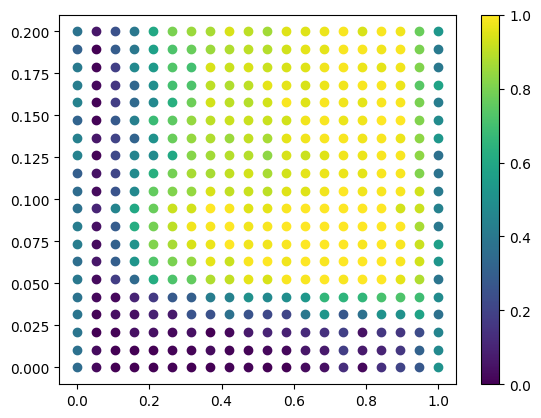

此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像


In [ ]:

#固定的参数

Z_L=0
for SNRRR in [16,24]:
    plt.figure()
    for I_tt in np.linspace(0,1,20):
        for dtt in np.linspace(0,0.2,20):
            try:
                all_x_vail_data=np.load(f'/home/DATA/suntianyang/gw_len/data/I_dt/test_SIS_{2}_data_{I_tt}_{dtt}_{SNRRR}.npy')
                all_x_vail_data=torch.tensor(all_x_vail_data,dtype=torch.float32)
            except:
                print('此条件不可能两个像')
            all_x_vail=get_wave_plus_gaosnoise_t_gen_cai_NPE(all_x_vail_data).reshape(-1,2,2**5)

            y_pre_all=[]
            for i in range(all_x_vail.shape[0]):
                model_NPE.eval()
                with torch.no_grad():
                    y_pre = torch.sigmoid(model_NPE(all_x_vail[i].cuda()[np.newaxis, :]))
                y_pre_all.append(float(y_pre))

            
            threshold = 0.8
            # 根据阈值确定预测标签
            y_pre = (np.array(y_pre_all) >= threshold).astype(int)
            plt.scatter(I_tt,dtt,c=sum(y_pre)/100, vmin=0, vmax=1)



                        
    plt.colorbar()
    plt.show()

这段代码进一步展开了之前讨论的内容，但引入了一个异常处理（`try-except`）块来处理可能发生的数据加载问题。具体地，当尝试加载不存在的文件或者当某些参数组合不适用时，它会捕获异常并打印一条消息：“此条件不可能两个像”，意味着对于某些参数组合，预期的数据文件不存在或者不可用。

### 异常处理的引入
- `try`块尝试加载指定路径的数据文件。文件名包括`I_tt`和`dtt`的值以及信噪比（SNR）值`SNRRR`，文件路径指示这是一个特定类型的测试数据（标记为`test_SIS_{2}_data`）。
- 如果数据文件不存在或有其他问题导致`np.load`函数抛出异常，`except`块将捕获这个异常并打印一条消息，提示用户当前参数组合下没有可用的数据。

### 数据处理与模型预测
- 如果成功加载了数据，它将被转换为PyTorch张量，并通过`get_wave_plus_gaosnoise_t_gen_cai_NPE`函数处理，该函数可能涉及数据的进一步转换或样本的生成。
- 对于生成的每个样本，模型`model_NPE`在评估模式下进行预测，不进行梯度计算。
- 模型输出通过sigmoid函数转换为概率值，并根据设定的阈值（0.8）判断为正类（1）或负类（0）。

### 可视化
- 使用`plt.scatter`将每一组`I_tt`和`dtt`参数的预测结果可视化，其中点的颜色表示预测为正类的样本比例。
- 循环结束后，为每个SNR值绘制一个散点图，并通过色标显示预测为正类的比例。

### 异常处理的意义
引入异常处理增加了代码的健壮性，使其能够处理数据文件缺失或不完整的情况，而不会导致整个程序终止。这对于实验或数据分析中常见的情况非常有用，其中某些数据可能由于各种原因（例如计算资源限制或实验条件限制）不可用。通过这种方式，可以确保分析的其他部分仍然可以继续进行，同时为数据缺失提供明确的反馈。

In [ ]:

#固定的参数

Z_L=0
for SNRRR in [24]:
    plt.figure()
    for I_tt in np.linspace(0,1,20):
        for dtt in np.linspace(0,0.2,20):
            try:
                all_x_vail_data=np.load(f'/home/DATA/suntianyang/gw_len/data/I_dt/test_SIS_{2}_data_{I_tt}_{dtt}_{SNRRR}.npy')
                all_x_vail_data=torch.tensor(all_x_vail_data,dtype=torch.float32)
            except:
                print('此条件不可能两个像')
            all_x_vail=get_wave_plus_gaosnoise_t_gen_cai_NPE(all_x_vail_data).reshape(-1,2,2**5)

            y_pre_all=[]
            for i in range(all_x_vail.shape[0]):
                model_NPE.eval()
                with torch.no_grad():
                    y_pre = torch.sigmoid(model_NPE(all_x_vail[i].cuda()[np.newaxis, :]))
                y_pre_all.append(float(y_pre))

            
            threshold = 0.8
            # 根据阈值确定预测标签
            y_pre = (np.array(y_pre_all) >= threshold).astype(int)
            plt.scatter(I_tt,dtt,c=sum(y_pre)/100, vmin=0, vmax=1)



                        
    plt.colorbar()
    plt.show()

此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
